In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
import keras

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(path='mnist.pkl.gz')
 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [3]:
x_train = x_train[:10000]

In [4]:
#my tips:Gauss sampling,sample Z
def sampling(args): 
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


#my tips:loss(restruct X)+KL
def vae_loss(x, x_decoded_mean):
    #my tips:logloss
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    #my tips:see paper's appendix B
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [13]:
batch_size = 100
original_dim = 784   #28*28
latent_dim = 2
intermediate_dim = 200
nb_epoch = 3000
epsilon_std = 1.0

In [14]:
#my tips:encoding
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [15]:
# note that "output_shape" isn't necessary with the TensorFlow backend
# my tips:get sample z(encoded)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
 
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [16]:
#This model will include all layers required in the computation of x given x_decoded_mean.
adam = keras.optimizers.Adam(lr=0.01, beta_1=0.99, beta_2=0.999, amsgrad=False)
vae = Model(x, x_decoded_mean)
vae.compile(optimizer=adam, loss=vae_loss)

In [17]:
# train the VAE on MNIST digits
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        verbose=2,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 10000 samples, validate on 10000 samples
Epoch 1/3000
 - 2s - loss: 211.9047 - val_loss: 188.1316
Epoch 2/3000
 - 2s - loss: 181.7690 - val_loss: 177.8867
Epoch 3/3000
 - 1s - loss: 174.5675 - val_loss: 173.3533
Epoch 4/3000
 - 1s - loss: 170.1250 - val_loss: 169.7750
Epoch 5/3000
 - 1s - loss: 167.5094 - val_loss: 168.0093
Epoch 6/3000
 - 1s - loss: 165.9440 - val_loss: 166.8250
Epoch 7/3000
 - 1s - loss: 164.6420 - val_loss: 165.8409
Epoch 8/3000
 - 1s - loss: 163.6494 - val_loss: 165.0425
Epoch 9/3000
 - 1s - loss: 162.8987 - val_loss: 164.3797
Epoch 10/3000
 - 1s - loss: 162.7129 - val_loss: 164.3214
Epoch 11/3000
 - 1s - loss: 162.0282 - val_loss: 163.3824
Epoch 12/3000
 - 1s - loss: 161.1362 - val_loss: 163.1179
Epoch 13/3000
 - 1s - loss: 160.5045 - val_loss: 162.2436
Epoch 14/3000
 - 1s - loss: 160.1213 - val_loss: 162.0309
Epoch 15/3000
 - 1s - loss: 159.7242 - val_loss: 161.8677
Epoch 16/3000
 - 1s - loss: 159.5120 - val_loss: 161.6019
Epoch 17/3000
 - 1s - loss: 159

Epoch 141/3000
 - 2s - loss: 149.4433 - val_loss: 159.1602
Epoch 142/3000
 - 2s - loss: 149.5823 - val_loss: 159.5734
Epoch 143/3000
 - 2s - loss: 149.7094 - val_loss: 159.5675
Epoch 144/3000
 - 2s - loss: 149.8752 - val_loss: 159.9115
Epoch 145/3000
 - 2s - loss: 149.7080 - val_loss: 159.8141
Epoch 146/3000
 - 2s - loss: 149.6443 - val_loss: 159.4968
Epoch 147/3000
 - 2s - loss: 149.6765 - val_loss: 159.7778
Epoch 148/3000
 - 2s - loss: 149.3128 - val_loss: 159.2231
Epoch 149/3000
 - 2s - loss: 149.5468 - val_loss: 159.8118
Epoch 150/3000
 - 2s - loss: 150.0784 - val_loss: 159.9951
Epoch 151/3000
 - 2s - loss: 149.9237 - val_loss: 159.0947
Epoch 152/3000
 - 3s - loss: 149.4766 - val_loss: 159.5203
Epoch 153/3000
 - 2s - loss: 149.7048 - val_loss: 159.5550
Epoch 154/3000
 - 2s - loss: 149.7175 - val_loss: 159.8980
Epoch 155/3000
 - 2s - loss: 149.5217 - val_loss: 159.2079
Epoch 156/3000
 - 2s - loss: 149.2791 - val_loss: 159.3987
Epoch 157/3000
 - 2s - loss: 149.6257 - val_loss: 159.48

Epoch 280/3000
 - 2s - loss: 147.8939 - val_loss: 160.3510
Epoch 281/3000
 - 2s - loss: 147.9558 - val_loss: 160.6177
Epoch 282/3000
 - 2s - loss: 148.7639 - val_loss: 161.1441
Epoch 283/3000
 - 2s - loss: 148.5924 - val_loss: 160.9050
Epoch 284/3000
 - 2s - loss: 148.3760 - val_loss: 160.6322
Epoch 285/3000
 - 2s - loss: 147.8651 - val_loss: 160.3708
Epoch 286/3000
 - 2s - loss: 147.9997 - val_loss: 160.5870
Epoch 287/3000
 - 2s - loss: 148.3664 - val_loss: 160.5554
Epoch 288/3000
 - 2s - loss: 148.0984 - val_loss: 160.2862
Epoch 289/3000
 - 2s - loss: 147.8637 - val_loss: 160.5587
Epoch 290/3000
 - 2s - loss: 147.8652 - val_loss: 160.1981
Epoch 291/3000
 - 2s - loss: 147.8798 - val_loss: 160.2254
Epoch 292/3000
 - 2s - loss: 147.7698 - val_loss: 160.3542
Epoch 293/3000
 - 2s - loss: 148.1943 - val_loss: 160.7435
Epoch 294/3000
 - 2s - loss: 148.6664 - val_loss: 160.7124
Epoch 295/3000
 - 2s - loss: 148.8615 - val_loss: 161.3680
Epoch 296/3000
 - 2s - loss: 148.2133 - val_loss: 160.53

Epoch 419/3000
 - 2s - loss: 148.2172 - val_loss: 161.6777
Epoch 420/3000
 - 2s - loss: 147.7308 - val_loss: 161.2528
Epoch 421/3000
 - 2s - loss: 147.7598 - val_loss: 161.1182
Epoch 422/3000
 - 2s - loss: 147.6691 - val_loss: 161.0892
Epoch 423/3000
 - 2s - loss: 147.5091 - val_loss: 161.4453
Epoch 424/3000
 - 2s - loss: 147.3717 - val_loss: 160.9304
Epoch 425/3000
 - 2s - loss: 147.5489 - val_loss: 161.4460
Epoch 426/3000
 - 2s - loss: 147.5617 - val_loss: 161.4066
Epoch 427/3000
 - 2s - loss: 147.3399 - val_loss: 161.0320
Epoch 428/3000
 - 2s - loss: 146.8915 - val_loss: 160.7950
Epoch 429/3000
 - 2s - loss: 146.8390 - val_loss: 160.5991
Epoch 430/3000
 - 2s - loss: 146.6905 - val_loss: 161.1040
Epoch 431/3000
 - 2s - loss: 147.2406 - val_loss: 161.1440
Epoch 432/3000
 - 2s - loss: 147.8286 - val_loss: 161.6360
Epoch 433/3000
 - 2s - loss: 148.4149 - val_loss: 162.1561
Epoch 434/3000
 - 2s - loss: 149.3112 - val_loss: 162.3320
Epoch 435/3000
 - 2s - loss: 148.8593 - val_loss: 162.11

Epoch 558/3000
 - 2s - loss: 147.1846 - val_loss: 161.5528
Epoch 559/3000
 - 2s - loss: 147.2589 - val_loss: 161.6331
Epoch 560/3000
 - 2s - loss: 147.0661 - val_loss: 162.1615
Epoch 561/3000
 - 2s - loss: 146.7315 - val_loss: 161.7305
Epoch 562/3000
 - 2s - loss: 146.4509 - val_loss: 162.1277
Epoch 563/3000
 - 2s - loss: 146.6521 - val_loss: 161.4033
Epoch 564/3000
 - 2s - loss: 147.1142 - val_loss: 161.9666
Epoch 565/3000
 - 2s - loss: 148.0778 - val_loss: 162.3263
Epoch 566/3000
 - 2s - loss: 147.7751 - val_loss: 162.0375
Epoch 567/3000
 - 2s - loss: 148.7689 - val_loss: 162.7235
Epoch 568/3000
 - 2s - loss: 148.6420 - val_loss: 163.1353
Epoch 569/3000
 - 2s - loss: 149.4873 - val_loss: 164.3194
Epoch 570/3000
 - 2s - loss: 149.0699 - val_loss: 162.6619
Epoch 571/3000
 - 2s - loss: 148.5042 - val_loss: 162.2103
Epoch 572/3000
 - 2s - loss: 148.1420 - val_loss: 161.7834
Epoch 573/3000
 - 2s - loss: 147.6858 - val_loss: 161.7647
Epoch 574/3000
 - 2s - loss: 147.3140 - val_loss: 161.81

Epoch 697/3000
 - 2s - loss: 147.5876 - val_loss: 162.2015
Epoch 698/3000
 - 2s - loss: 147.3765 - val_loss: 162.2233
Epoch 699/3000
 - 2s - loss: 147.2410 - val_loss: 162.1534
Epoch 700/3000
 - 2s - loss: 147.5684 - val_loss: 163.1699
Epoch 701/3000
 - 2s - loss: 147.6019 - val_loss: 162.2409
Epoch 702/3000
 - 2s - loss: 147.1827 - val_loss: 162.5516
Epoch 703/3000
 - 2s - loss: 146.9443 - val_loss: 161.4812
Epoch 704/3000
 - 2s - loss: 146.5613 - val_loss: 161.8428
Epoch 705/3000
 - 2s - loss: 146.6885 - val_loss: 162.3819
Epoch 706/3000
 - 2s - loss: 146.5629 - val_loss: 162.1520
Epoch 707/3000
 - 2s - loss: 146.3435 - val_loss: 162.1715
Epoch 708/3000
 - 2s - loss: 146.9952 - val_loss: 162.4116
Epoch 709/3000
 - 2s - loss: 146.6837 - val_loss: 162.2648
Epoch 710/3000
 - 2s - loss: 146.5609 - val_loss: 162.7180
Epoch 711/3000
 - 2s - loss: 146.7163 - val_loss: 163.1534
Epoch 712/3000
 - 2s - loss: 146.8236 - val_loss: 162.1196
Epoch 713/3000
 - 2s - loss: 146.8553 - val_loss: 162.52

Epoch 836/3000
 - 2s - loss: 147.0602 - val_loss: 162.3607
Epoch 837/3000
 - 2s - loss: 146.6148 - val_loss: 163.1261
Epoch 838/3000
 - 2s - loss: 147.0505 - val_loss: 163.5038
Epoch 839/3000
 - 2s - loss: 146.9767 - val_loss: 162.4058
Epoch 840/3000
 - 2s - loss: 146.5267 - val_loss: 162.1562
Epoch 841/3000
 - 2s - loss: 146.5870 - val_loss: 162.8837
Epoch 842/3000
 - 2s - loss: 146.2183 - val_loss: 162.9296
Epoch 843/3000
 - 2s - loss: 146.1798 - val_loss: 162.3890
Epoch 844/3000
 - 2s - loss: 146.2630 - val_loss: 161.9431
Epoch 845/3000
 - 2s - loss: 146.3524 - val_loss: 162.4601
Epoch 846/3000
 - 3s - loss: 146.8592 - val_loss: 162.1137
Epoch 847/3000
 - 3s - loss: 147.0578 - val_loss: 163.1573
Epoch 848/3000
 - 2s - loss: 146.8690 - val_loss: 162.6665
Epoch 849/3000
 - 2s - loss: 146.7543 - val_loss: 162.7983
Epoch 850/3000
 - 2s - loss: 147.0737 - val_loss: 162.8499
Epoch 851/3000
 - 2s - loss: 146.6201 - val_loss: 162.8045
Epoch 852/3000
 - 2s - loss: 146.5577 - val_loss: 163.19

Epoch 975/3000
 - 2s - loss: 146.8822 - val_loss: 163.3848
Epoch 976/3000
 - 2s - loss: 146.4062 - val_loss: 162.6530
Epoch 977/3000
 - 2s - loss: 146.7312 - val_loss: 162.9585
Epoch 978/3000
 - 2s - loss: 146.7453 - val_loss: 163.0698
Epoch 979/3000
 - 2s - loss: 146.6709 - val_loss: 163.7662
Epoch 980/3000
 - 2s - loss: 147.3406 - val_loss: 164.1347
Epoch 981/3000
 - 2s - loss: 147.3334 - val_loss: 163.6978
Epoch 982/3000
 - 2s - loss: 147.7433 - val_loss: 163.8934
Epoch 983/3000
 - 2s - loss: 148.2504 - val_loss: 164.0317
Epoch 984/3000
 - 2s - loss: 147.2201 - val_loss: 162.8761
Epoch 985/3000
 - 2s - loss: 146.2559 - val_loss: 162.7320
Epoch 986/3000
 - 2s - loss: 146.1205 - val_loss: 162.8902
Epoch 987/3000
 - 2s - loss: 145.9696 - val_loss: 162.5939
Epoch 988/3000
 - 2s - loss: 146.5561 - val_loss: 163.3814
Epoch 989/3000
 - 3s - loss: 146.8343 - val_loss: 163.8139
Epoch 990/3000
 - 3s - loss: 146.4656 - val_loss: 163.3838
Epoch 991/3000
 - 3s - loss: 146.6110 - val_loss: 162.97

Epoch 1112/3000
 - 3s - loss: 147.3317 - val_loss: 163.4536
Epoch 1113/3000
 - 3s - loss: 147.2886 - val_loss: 163.3792
Epoch 1114/3000
 - 2s - loss: 146.5880 - val_loss: 163.6396
Epoch 1115/3000
 - 2s - loss: 146.4490 - val_loss: 163.2788
Epoch 1116/3000
 - 2s - loss: 146.3210 - val_loss: 163.3562
Epoch 1117/3000
 - 3s - loss: 146.2842 - val_loss: 163.1390
Epoch 1118/3000
 - 2s - loss: 146.4387 - val_loss: 163.3927
Epoch 1119/3000
 - 3s - loss: 146.6888 - val_loss: 163.6464
Epoch 1120/3000
 - 3s - loss: 146.6845 - val_loss: 163.6594
Epoch 1121/3000
 - 3s - loss: 146.2968 - val_loss: 162.9528
Epoch 1122/3000
 - 2s - loss: 146.2948 - val_loss: 163.2633
Epoch 1123/3000
 - 2s - loss: 146.6085 - val_loss: 164.1005
Epoch 1124/3000
 - 2s - loss: 147.0613 - val_loss: 163.5776
Epoch 1125/3000
 - 2s - loss: 146.8759 - val_loss: 162.9797
Epoch 1126/3000
 - 3s - loss: 146.9964 - val_loss: 164.0266
Epoch 1127/3000
 - 3s - loss: 147.7472 - val_loss: 163.9167
Epoch 1128/3000
 - 3s - loss: 146.7851 -

Epoch 1249/3000
 - 2s - loss: 146.3644 - val_loss: 163.1272
Epoch 1250/3000
 - 3s - loss: 146.3719 - val_loss: 163.2266
Epoch 1251/3000
 - 3s - loss: 146.0850 - val_loss: 162.9350
Epoch 1252/3000
 - 2s - loss: 145.9531 - val_loss: 162.4009
Epoch 1253/3000
 - 2s - loss: 145.4989 - val_loss: 162.3241
Epoch 1254/3000
 - 2s - loss: 145.6251 - val_loss: 162.6540
Epoch 1255/3000
 - 2s - loss: 145.9271 - val_loss: 162.8989
Epoch 1256/3000
 - 2s - loss: 146.1925 - val_loss: 163.0823
Epoch 1257/3000
 - 3s - loss: 146.0694 - val_loss: 163.5544
Epoch 1258/3000
 - 3s - loss: 146.3621 - val_loss: 163.0932
Epoch 1259/3000
 - 3s - loss: 146.7884 - val_loss: 163.4000
Epoch 1260/3000
 - 2s - loss: 146.4165 - val_loss: 163.6634
Epoch 1261/3000
 - 3s - loss: 147.1030 - val_loss: 164.0160
Epoch 1262/3000
 - 2s - loss: 147.2790 - val_loss: 163.9840
Epoch 1263/3000
 - 2s - loss: 147.0345 - val_loss: 164.0810
Epoch 1264/3000
 - 2s - loss: 147.4436 - val_loss: 164.3659
Epoch 1265/3000
 - 2s - loss: 146.9172 -

Epoch 1386/3000
 - 2s - loss: 145.9585 - val_loss: 162.9929
Epoch 1387/3000
 - 2s - loss: 146.2513 - val_loss: 163.8492
Epoch 1388/3000
 - 2s - loss: 146.3891 - val_loss: 163.5592
Epoch 1389/3000
 - 2s - loss: 146.3183 - val_loss: 163.2297
Epoch 1390/3000
 - 2s - loss: 147.0250 - val_loss: 163.3213
Epoch 1391/3000
 - 2s - loss: 146.4706 - val_loss: 163.4473
Epoch 1392/3000
 - 2s - loss: 146.5224 - val_loss: 163.3384
Epoch 1393/3000
 - 2s - loss: 146.4356 - val_loss: 163.3173
Epoch 1394/3000
 - 2s - loss: 146.2087 - val_loss: 163.2022
Epoch 1395/3000
 - 2s - loss: 145.8421 - val_loss: 162.9425
Epoch 1396/3000
 - 2s - loss: 145.9500 - val_loss: 162.7254
Epoch 1397/3000
 - 2s - loss: 146.2975 - val_loss: 163.7579
Epoch 1398/3000
 - 2s - loss: 146.0407 - val_loss: 163.0330
Epoch 1399/3000
 - 2s - loss: 146.0593 - val_loss: 163.6330
Epoch 1400/3000
 - 2s - loss: 146.3387 - val_loss: 163.4733
Epoch 1401/3000
 - 2s - loss: 146.1144 - val_loss: 164.2061
Epoch 1402/3000
 - 2s - loss: 146.2145 -

Epoch 1523/3000
 - 4s - loss: 146.9472 - val_loss: 164.4177
Epoch 1524/3000
 - 5s - loss: 146.8200 - val_loss: 163.2729
Epoch 1525/3000
 - 4s - loss: 146.4837 - val_loss: 164.1843
Epoch 1526/3000
 - 2s - loss: 147.0732 - val_loss: 163.6911
Epoch 1527/3000
 - 3s - loss: 147.6452 - val_loss: 164.5311
Epoch 1528/3000
 - 3s - loss: 147.3164 - val_loss: 164.0927
Epoch 1529/3000
 - 2s - loss: 146.5056 - val_loss: 163.5876
Epoch 1530/3000
 - 3s - loss: 145.6547 - val_loss: 163.5139
Epoch 1531/3000
 - 2s - loss: 145.8430 - val_loss: 164.1811
Epoch 1532/3000
 - 2s - loss: 146.1651 - val_loss: 163.3582
Epoch 1533/3000
 - 2s - loss: 146.1500 - val_loss: 163.8489
Epoch 1534/3000
 - 2s - loss: 146.1983 - val_loss: 163.5578
Epoch 1535/3000
 - 2s - loss: 146.3231 - val_loss: 163.2743
Epoch 1536/3000
 - 2s - loss: 145.8229 - val_loss: 163.1294
Epoch 1537/3000
 - 2s - loss: 145.8125 - val_loss: 163.5402
Epoch 1538/3000
 - 2s - loss: 146.2637 - val_loss: 163.2864
Epoch 1539/3000
 - 2s - loss: 146.5885 -

Epoch 1660/3000
 - 2s - loss: 147.3938 - val_loss: 165.7411
Epoch 1661/3000
 - 2s - loss: 147.1241 - val_loss: 163.9001
Epoch 1662/3000
 - 2s - loss: 146.5048 - val_loss: 163.2413
Epoch 1663/3000
 - 2s - loss: 146.6451 - val_loss: 163.4727
Epoch 1664/3000
 - 2s - loss: 146.2799 - val_loss: 163.2784
Epoch 1665/3000
 - 2s - loss: 146.1449 - val_loss: 163.8341
Epoch 1666/3000
 - 2s - loss: 146.0021 - val_loss: 163.3857
Epoch 1667/3000
 - 2s - loss: 146.0829 - val_loss: 164.8397
Epoch 1668/3000
 - 2s - loss: 146.4809 - val_loss: 164.3805
Epoch 1669/3000
 - 2s - loss: 146.3438 - val_loss: 163.0574
Epoch 1670/3000
 - 2s - loss: 145.9296 - val_loss: 162.9838
Epoch 1671/3000
 - 2s - loss: 145.8853 - val_loss: 163.3418
Epoch 1672/3000
 - 2s - loss: 146.2628 - val_loss: 163.3857
Epoch 1673/3000
 - 2s - loss: 145.9172 - val_loss: 163.4473
Epoch 1674/3000
 - 2s - loss: 146.0748 - val_loss: 163.3483
Epoch 1675/3000
 - 2s - loss: 145.8307 - val_loss: 163.9682
Epoch 1676/3000
 - 2s - loss: 146.1009 -

Epoch 1797/3000
 - 2s - loss: 146.9448 - val_loss: 163.9697
Epoch 1798/3000
 - 2s - loss: 146.0544 - val_loss: 163.8563
Epoch 1799/3000
 - 2s - loss: 145.8989 - val_loss: 164.0982
Epoch 1800/3000
 - 2s - loss: 146.2423 - val_loss: 163.8197
Epoch 1801/3000
 - 2s - loss: 146.8092 - val_loss: 164.8272
Epoch 1802/3000
 - 2s - loss: 147.3867 - val_loss: 163.5738
Epoch 1803/3000
 - 2s - loss: 146.9037 - val_loss: 164.3480
Epoch 1804/3000
 - 2s - loss: 146.4964 - val_loss: 163.8133
Epoch 1805/3000
 - 2s - loss: 146.2650 - val_loss: 163.3766
Epoch 1806/3000
 - 2s - loss: 146.3337 - val_loss: 163.8167
Epoch 1807/3000
 - 2s - loss: 146.6070 - val_loss: 164.1992
Epoch 1808/3000
 - 2s - loss: 146.6640 - val_loss: 164.1804
Epoch 1809/3000
 - 2s - loss: 146.1812 - val_loss: 163.7573
Epoch 1810/3000
 - 2s - loss: 146.3042 - val_loss: 163.4896
Epoch 1811/3000
 - 2s - loss: 145.6346 - val_loss: 163.2069
Epoch 1812/3000
 - 2s - loss: 146.0059 - val_loss: 163.5657
Epoch 1813/3000
 - 2s - loss: 146.4756 -

Epoch 1934/3000
 - 2s - loss: 146.2840 - val_loss: 163.7956
Epoch 1935/3000
 - 2s - loss: 146.4842 - val_loss: 164.0386
Epoch 1936/3000
 - 2s - loss: 146.4799 - val_loss: 163.8483
Epoch 1937/3000
 - 2s - loss: 147.4154 - val_loss: 164.7995
Epoch 1938/3000
 - 2s - loss: 146.4944 - val_loss: 164.7463
Epoch 1939/3000
 - 2s - loss: 146.5534 - val_loss: 164.5763
Epoch 1940/3000
 - 2s - loss: 146.7475 - val_loss: 164.0408
Epoch 1941/3000
 - 2s - loss: 146.9466 - val_loss: 163.7917
Epoch 1942/3000
 - 2s - loss: 146.3654 - val_loss: 164.1553
Epoch 1943/3000
 - 2s - loss: 146.6132 - val_loss: 164.4310
Epoch 1944/3000
 - 2s - loss: 146.1756 - val_loss: 163.4577
Epoch 1945/3000
 - 2s - loss: 145.9973 - val_loss: 163.4667
Epoch 1946/3000
 - 2s - loss: 145.8325 - val_loss: 164.1240
Epoch 1947/3000
 - 2s - loss: 145.7227 - val_loss: 163.3392
Epoch 1948/3000
 - 2s - loss: 146.2425 - val_loss: 163.4996
Epoch 1949/3000
 - 2s - loss: 146.9780 - val_loss: 163.6593
Epoch 1950/3000
 - 2s - loss: 147.4124 -

Epoch 2071/3000
 - 2s - loss: 146.1259 - val_loss: 164.4817
Epoch 2072/3000
 - 2s - loss: 145.3923 - val_loss: 163.5194
Epoch 2073/3000
 - 2s - loss: 145.4776 - val_loss: 163.3785
Epoch 2074/3000
 - 2s - loss: 146.2712 - val_loss: 163.9484
Epoch 2075/3000
 - 2s - loss: 146.1773 - val_loss: 164.3572
Epoch 2076/3000
 - 2s - loss: 145.5564 - val_loss: 164.4192
Epoch 2077/3000
 - 2s - loss: 145.8164 - val_loss: 163.9725
Epoch 2078/3000
 - 2s - loss: 146.2128 - val_loss: 164.0157
Epoch 2079/3000
 - 2s - loss: 145.8710 - val_loss: 164.3224
Epoch 2080/3000
 - 2s - loss: 145.9342 - val_loss: 163.8594
Epoch 2081/3000
 - 2s - loss: 146.2252 - val_loss: 163.6825
Epoch 2082/3000
 - 2s - loss: 145.9034 - val_loss: 164.1461
Epoch 2083/3000
 - 2s - loss: 146.2139 - val_loss: 164.2919
Epoch 2084/3000
 - 2s - loss: 146.0078 - val_loss: 163.9841
Epoch 2085/3000
 - 2s - loss: 146.1354 - val_loss: 164.1730
Epoch 2086/3000
 - 2s - loss: 146.4984 - val_loss: 164.3967
Epoch 2087/3000
 - 2s - loss: 146.1918 -

Epoch 2208/3000
 - 2s - loss: 146.1820 - val_loss: 164.7016
Epoch 2209/3000
 - 2s - loss: 147.3018 - val_loss: 164.4532
Epoch 2210/3000
 - 2s - loss: 146.5503 - val_loss: 164.2183
Epoch 2211/3000
 - 2s - loss: 145.7614 - val_loss: 163.7102
Epoch 2212/3000
 - 2s - loss: 145.5893 - val_loss: 163.3182
Epoch 2213/3000
 - 2s - loss: 145.7518 - val_loss: 163.9484
Epoch 2214/3000
 - 2s - loss: 145.8307 - val_loss: 164.1623
Epoch 2215/3000
 - 2s - loss: 145.7994 - val_loss: 163.3657
Epoch 2216/3000
 - 2s - loss: 145.7036 - val_loss: 164.0285
Epoch 2217/3000
 - 2s - loss: 145.8978 - val_loss: 164.4323
Epoch 2218/3000
 - 2s - loss: 145.9903 - val_loss: 164.2709
Epoch 2219/3000
 - 2s - loss: 146.7848 - val_loss: 164.7509
Epoch 2220/3000
 - 2s - loss: 147.1622 - val_loss: 163.8746
Epoch 2221/3000
 - 2s - loss: 146.6899 - val_loss: 164.5554
Epoch 2222/3000
 - 2s - loss: 145.7043 - val_loss: 163.4852
Epoch 2223/3000
 - 2s - loss: 146.1211 - val_loss: 163.8768
Epoch 2224/3000
 - 2s - loss: 146.0308 -

Epoch 2345/3000
 - 2s - loss: 145.7761 - val_loss: 163.8290
Epoch 2346/3000
 - 2s - loss: 146.4363 - val_loss: 165.1114
Epoch 2347/3000
 - 2s - loss: 146.6439 - val_loss: 164.4133
Epoch 2348/3000
 - 2s - loss: 146.0433 - val_loss: 164.2115
Epoch 2349/3000
 - 2s - loss: 145.8255 - val_loss: 163.9518
Epoch 2350/3000
 - 2s - loss: 145.7579 - val_loss: 164.1359
Epoch 2351/3000
 - 2s - loss: 145.9736 - val_loss: 165.0274
Epoch 2352/3000
 - 2s - loss: 146.1594 - val_loss: 165.1001
Epoch 2353/3000
 - 2s - loss: 146.6890 - val_loss: 164.4931
Epoch 2354/3000
 - 2s - loss: 146.1048 - val_loss: 164.5122
Epoch 2355/3000
 - 2s - loss: 146.1756 - val_loss: 163.9138
Epoch 2356/3000
 - 2s - loss: 146.7756 - val_loss: 164.6624
Epoch 2357/3000
 - 2s - loss: 146.6650 - val_loss: 164.0374
Epoch 2358/3000
 - 2s - loss: 146.3329 - val_loss: 164.3712
Epoch 2359/3000
 - 2s - loss: 146.2509 - val_loss: 164.4111
Epoch 2360/3000
 - 2s - loss: 146.3736 - val_loss: 163.9903
Epoch 2361/3000
 - 2s - loss: 146.4726 -

Epoch 2482/3000
 - 2s - loss: 145.7833 - val_loss: 163.8136
Epoch 2483/3000
 - 2s - loss: 145.8338 - val_loss: 164.4905
Epoch 2484/3000
 - 2s - loss: 146.3550 - val_loss: 164.4936
Epoch 2485/3000
 - 2s - loss: 148.0029 - val_loss: 165.7688
Epoch 2486/3000
 - 2s - loss: 148.1177 - val_loss: 165.7060
Epoch 2487/3000
 - 2s - loss: 147.4315 - val_loss: 165.6531
Epoch 2488/3000
 - 2s - loss: 147.2898 - val_loss: 165.3243
Epoch 2489/3000
 - 2s - loss: 146.9959 - val_loss: 164.8055
Epoch 2490/3000
 - 2s - loss: 146.3983 - val_loss: 164.3034
Epoch 2491/3000
 - 2s - loss: 145.9733 - val_loss: 163.8579
Epoch 2492/3000
 - 2s - loss: 146.0800 - val_loss: 165.1232
Epoch 2493/3000
 - 2s - loss: 146.9278 - val_loss: 164.2272
Epoch 2494/3000
 - 2s - loss: 146.3467 - val_loss: 164.5885
Epoch 2495/3000
 - 2s - loss: 145.8740 - val_loss: 164.7263
Epoch 2496/3000
 - 2s - loss: 145.6902 - val_loss: 163.8468
Epoch 2497/3000
 - 2s - loss: 145.8173 - val_loss: 164.1339
Epoch 2498/3000
 - 2s - loss: 146.1048 -

Epoch 2619/3000
 - 2s - loss: 145.3298 - val_loss: 163.9186
Epoch 2620/3000
 - 2s - loss: 145.4436 - val_loss: 163.8518
Epoch 2621/3000
 - 2s - loss: 146.0656 - val_loss: 163.8015
Epoch 2622/3000
 - 2s - loss: 146.5307 - val_loss: 164.3325
Epoch 2623/3000
 - 2s - loss: 146.2703 - val_loss: 164.3978
Epoch 2624/3000
 - 2s - loss: 146.7624 - val_loss: 165.6277
Epoch 2625/3000
 - 2s - loss: 146.7835 - val_loss: 164.3896
Epoch 2626/3000
 - 2s - loss: 147.1725 - val_loss: 164.8365
Epoch 2627/3000
 - 2s - loss: 147.7586 - val_loss: 164.9423
Epoch 2628/3000
 - 2s - loss: 146.9710 - val_loss: 164.3322
Epoch 2629/3000
 - 2s - loss: 145.7726 - val_loss: 164.3872
Epoch 2630/3000
 - 2s - loss: 145.9085 - val_loss: 164.6038
Epoch 2631/3000
 - 2s - loss: 146.4018 - val_loss: 164.7140
Epoch 2632/3000
 - 2s - loss: 146.5679 - val_loss: 166.1433
Epoch 2633/3000
 - 2s - loss: 147.0095 - val_loss: 164.6955
Epoch 2634/3000
 - 2s - loss: 146.0786 - val_loss: 163.6790
Epoch 2635/3000
 - 2s - loss: 146.0906 -

Epoch 2756/3000
 - 2s - loss: 146.2578 - val_loss: 165.3691
Epoch 2757/3000
 - 2s - loss: 146.4329 - val_loss: 164.7163
Epoch 2758/3000
 - 2s - loss: 146.5168 - val_loss: 164.5035
Epoch 2759/3000
 - 2s - loss: 147.0555 - val_loss: 165.5876
Epoch 2760/3000
 - 2s - loss: 146.1734 - val_loss: 164.2297
Epoch 2761/3000
 - 2s - loss: 145.8296 - val_loss: 163.9814
Epoch 2762/3000
 - 2s - loss: 146.3717 - val_loss: 165.4402
Epoch 2763/3000
 - 2s - loss: 146.4930 - val_loss: 164.4696
Epoch 2764/3000
 - 2s - loss: 145.4409 - val_loss: 164.3623
Epoch 2765/3000
 - 2s - loss: 145.6535 - val_loss: 165.0891
Epoch 2766/3000
 - 2s - loss: 146.6813 - val_loss: 164.8723
Epoch 2767/3000
 - 2s - loss: 146.9427 - val_loss: 165.5086
Epoch 2768/3000
 - 2s - loss: 146.4858 - val_loss: 164.9105
Epoch 2769/3000
 - 2s - loss: 146.0809 - val_loss: 164.8926
Epoch 2770/3000
 - 2s - loss: 146.5655 - val_loss: 164.8771
Epoch 2771/3000
 - 2s - loss: 146.2312 - val_loss: 164.5687
Epoch 2772/3000
 - 2s - loss: 146.0091 -

Epoch 2893/3000
 - 2s - loss: 146.0522 - val_loss: 165.5916
Epoch 2894/3000
 - 2s - loss: 146.3167 - val_loss: 164.5487
Epoch 2895/3000
 - 2s - loss: 146.0599 - val_loss: 164.6837
Epoch 2896/3000
 - 2s - loss: 146.1123 - val_loss: 164.7315
Epoch 2897/3000
 - 2s - loss: 146.1041 - val_loss: 164.9406
Epoch 2898/3000
 - 2s - loss: 146.0792 - val_loss: 164.7796
Epoch 2899/3000
 - 2s - loss: 146.2028 - val_loss: 164.9436
Epoch 2900/3000
 - 2s - loss: 146.6927 - val_loss: 165.0048
Epoch 2901/3000
 - 2s - loss: 146.1670 - val_loss: 164.9968
Epoch 2902/3000
 - 2s - loss: 145.9725 - val_loss: 165.3837
Epoch 2903/3000
 - 2s - loss: 145.9338 - val_loss: 163.9033
Epoch 2904/3000
 - 2s - loss: 146.3047 - val_loss: 163.9613
Epoch 2905/3000
 - 2s - loss: 146.3579 - val_loss: 164.7850
Epoch 2906/3000
 - 2s - loss: 145.8010 - val_loss: 164.2297
Epoch 2907/3000
 - 2s - loss: 145.5765 - val_loss: 164.2174
Epoch 2908/3000
 - 2s - loss: 146.7717 - val_loss: 165.0009
Epoch 2909/3000
 - 2s - loss: 146.0584 -

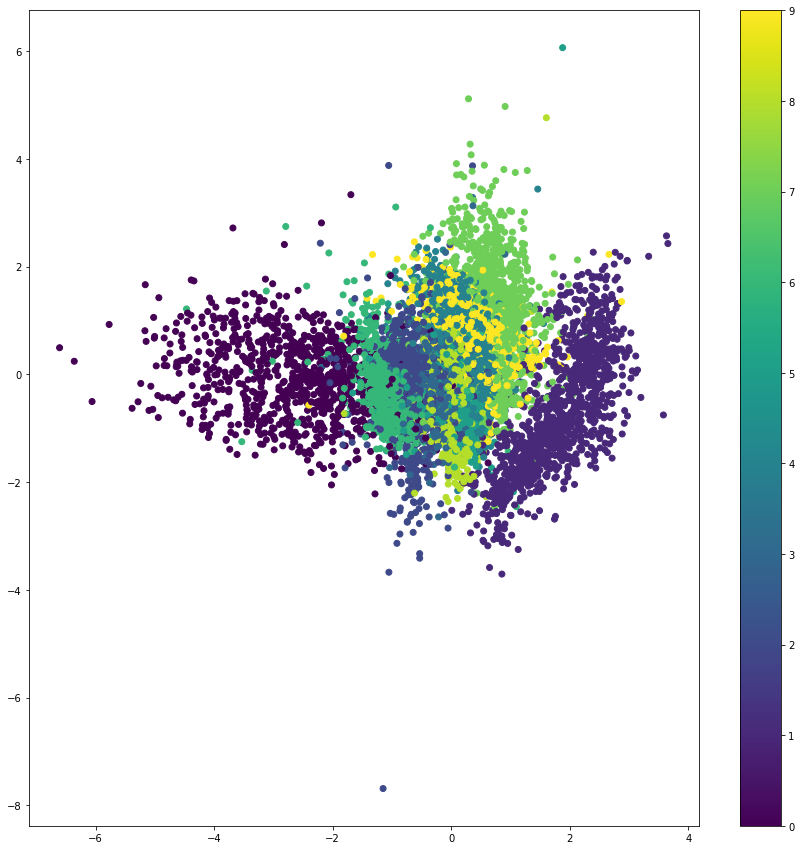

In [18]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
 
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(15,15))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
 
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

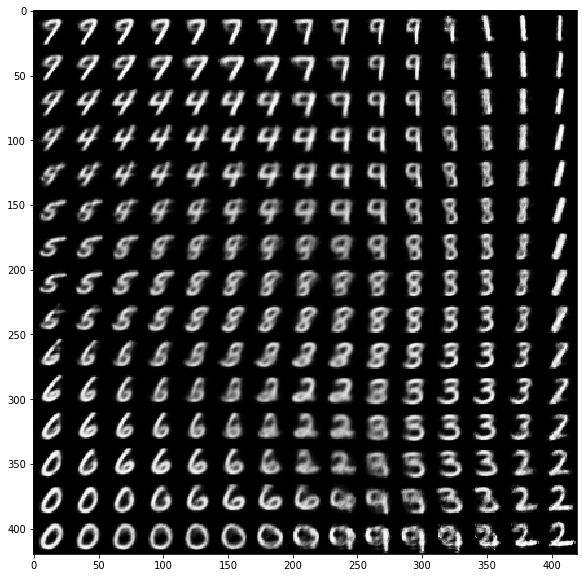

In [11]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
 
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        
 
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [12]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        print(yi)

-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.697141434846342
-0.697141434846342
-0.697141434846342
-0.697141434846342
-0.697141434846342
-0.697141434846342
-0.6971414348463